# L9b: Let's Explore the Perceptron on Non-Linearly Separable Data
In this lab, we'll investigate the performance of the Perceptron on datasets that are not linearly separable, particularly the XOR problem. The XOR problem is a classic example that demonstrates the limitations of single-layer linear classifiers.

> **Backstory:** In 1969, AI researchers [Marvin Minsky](https://en.wikipedia.org/wiki/Marvin_Minsky) and [Seymour Papert](https://en.wikipedia.org/wiki/Seymour_Papert) published a book called [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)), in which they proved that the Perceptron was incapable of learning certain functions, particularly the XOR function. This fundamental limitation—that the Perceptron cannot solve non-linearly separable problems—became a central point in their critique. Soon after the book was published, the first [AI winter](https://en.wikipedia.org/wiki/AI_winter) began. Whether these events are correlated remains an interesting historical question.

What are we going to do in this lab?

> **Learning objectives:**
>
> In this lab, students will learn to:
>
> * **Generate and visualize classification datasets with different separability properties.** We create synthetic datasets with configurable labeling functions (wedge, XOR, rotated half-circle), partition data into training and test sets, and visualize the spatial distribution of classes to assess whether patterns are linearly separable.
> * **Train and evaluate the Perceptron classifier.** We implement the Perceptron learning algorithm using online updates, systematically train on the training dataset, and compute classification metrics including confusion matrices and accuracy on unseen test data.
> * **Understand the limitations of linear classifiers on non-linearly separable problems.** We compare classifier performance when the true decision boundary is linear versus non-linear, demonstrating why the Perceptron fails on XOR-type patterns and gaining insight into the motivation for more complex models.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on Julia functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl"));

In addition to standard Julia libraries, we'll use [`VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material.

### Constants
Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

In [6]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary are class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [8]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

### Data
We'll use [the Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) and [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to classify datasets, including [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset (which may or may not be linearly separable), and then we'll split it into `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start with the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$. We'll build a label function $L:\mathbb{R}\times\mathbb{R}\to\{\text{true, false}\}$ (we can change this function around to get different labeling patterns):

In [10]:
# TODO: uncomment this logic for different labeling patterns
# L(x,y) = (y ≥ 0) ? true : false; # rotated half circle (linearly separable)
# L(x,y) = (x ≥ 0) && (y ≥ 0) ? true : false; # wedge pattern (not linearly separable)
# L(x,y) = xor(x ≥ 0,y ≥ 0); # XOR pattern alternating pie wedges (not linearly separable)

Generate the master dataset `D`:

In [12]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the index from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # compute the label by taking the XOR, OR, AND, etc functions
    for i ∈ 1:total_number_of_points
        flag = L(D[i,1],D[i,2]);
        if (flag == true)
            D[i,3] = 1
        else
            D[i,3] = -1
        end
    end

    # finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation to the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;

#### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D` which contains two continuous features and a label. The color indicates the label.

> __Summary__: We will get a different pattern of $\pm{1}$ labels depending on the labeling function logic $L(x_{1},x_{2})$ we used. The dark blue dots represent label `1`, while the orange data represents label `-1`. Our classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

So what do we see?

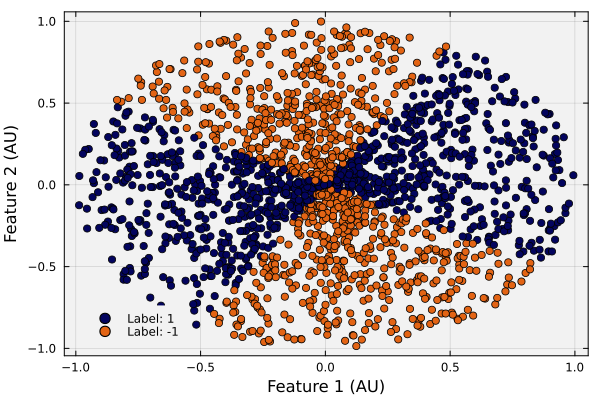

In [14]:
let

    dataset = D; # what dataset am I looking at?
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [16]:
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

__Visualize__ the `training` and `test` datasets. These should look like the original dataset `D`, just with fewer elements. We should not see an overrepresentation of a particular label because we selected the datasets at random.

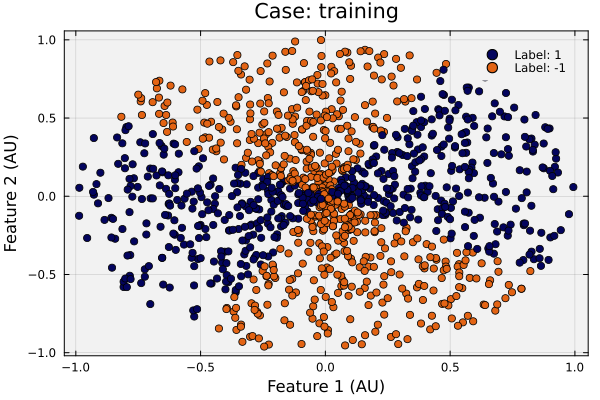

In [18]:
let

    dataset = training; # what dataset am I looking at?
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    caselabel = "training";
    if (dataset == test)
        caselabel="test";
    end
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    
    for i ∈ 1:number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("Case: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

## Task 2: Build a Perceptron Classification Model and Learn the Parameters
In this task, we'll build a model of our classification problem and train the model using an online learning method. 
* __Training__: Our Perceptron implementation [based on pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf) stores problem information in [a `MyPerceptronClassificationModel` instance, which holds the (initial) parameters and other data](src/Types.jl) required by the problem. We initialize the parameters using a vector of `1`'s.
* Next, we then _learn_ the model parameters [using the `learn(...)` method](src/Compute.jl), which takes the training features array `X,` the training labels vector `y`, and the problem instance and returns an updated problem instance holding the updated parameters. 

In [20]:
perceptron_model = let
    
    # setup
    D = training; # what dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features, what??
    y = D[:,end]; # output: this is the target data (label)
    
    # build an initial model
    model = build(MyPerceptronClassificationModel, (
        parameters = ones(number_of_features),
        mistakes = 0 # willing to live with m mistakes
    ));

    # TODO: uncomment me to train the model -
    trainedmodel = learn(X,y,model, maxiter = 1000, verbose = true);

    # return -
    trainedmodel;
end;

Stopped after number of iterations: 1000. We have number of errors: 578


__Inference__: Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between classes on data it has never seen. 
* We run the classification operation on the (unseen) test data [using the `classify(...)` method](src/Compute.jl). This method takes a feature array `X` and the (trained) model instance. It returns the estimated labels. We store the actual (correct) label in the `y_perceptron::Array{Int64,1}` vector, while the model predicted label is stored in the `ŷ_perceptron::Array{Int64,1}` array.

In [22]:
ŷ_perceptron,y_perceptron = let

    D = test; # what dataset are going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # TODO: uncomment to compute the estimated labels -
    ŷ = classify(X,perceptron_model)

    # return -
    ŷ,y
end;

__Confusion matrix__: The confusion matrix is a $2\times{2}$ matrix that contains four entries: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). [Click me for a confusion matrix schematic!](https://github.com/varnerlab/CHEME-5820-Labs-Spring-2025/blob/main/labs/week-3/L3b/figs/Fig-BinaryConfusionMatrix.pdf). 

Let's compute the confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_perceptron::Array{Int64,2}` variable:

In [24]:
CM_perceptron = confusion(y_perceptron, ŷ_perceptron)

2×2 Matrix{Int64}:
 211  210
 181  198

Finally, we can compute the overall error rate for the perceptron (or other performance metrics) using values from [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [26]:
number_of_test_points = length(y_perceptron);
correct_prediction_perceptron = CM_perceptron[1,1] + CM_perceptron[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.51125 Fraction incorrect 0.48875


__Visualize the misses__. Using the test dataset, let's show (with gray circles) which samples our classifier is unable to predict the label correctly, i.e., where we miss the label.

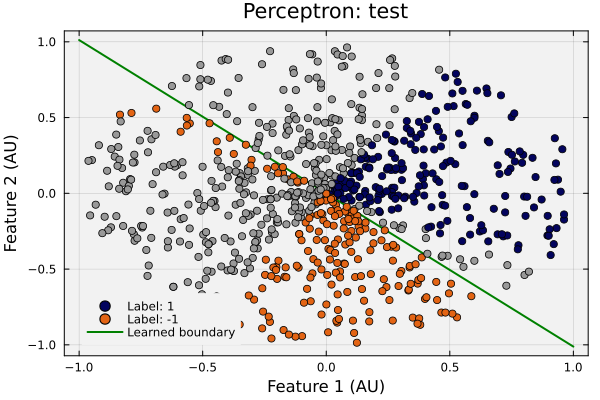

In [28]:
let

    model = perceptron_model; # which model am I using?
    dataset = test; # what dataset am I looking at?
    caselabel = "test";
    actual = y_perceptron;
    predicted = ŷ_perceptron;
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # let's draw the separating hyperplane (in our case, a line)
    p = model.β;
    number_of_plane_points = 200;
    x₂ = zeros(number_of_plane_points);
    x₁ = range(-1,stop=1,length = number_of_plane_points) |> collect;
    for i ∈ 1:number_of_plane_points
        x₂[i] = -1*((p[1]/p[2])*x₁[i] + p[3]/p[2]);
    end
    plot!(x₁,x₂,lw=2, c=:green, label="Learned boundary")
    
    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predicted label

        c = :gray60;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("Perceptron: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

___

## Summary
In this lab, we explored the Perceptron algorithm and its fundamental limitations on non-linearly separable datasets. 

> **Key takeaways:**
> * **Linear classifiers excel on linearly separable problems.** The Perceptron successfully learns decision boundaries when classes can be separated by a hyperplane, as demonstrated with our wedge pattern dataset where the linear classifier achieved strong performance.
> * **The XOR problem exposes fundamental limitations.** The Perceptron cannot learn the XOR function because the decision boundary required is non-linear, i.e., no single hyperplane can separate all data points correctly. This limitation, proved by Minsky and Papert in 1969, fundamentally challenged the optimism of early AI.
> * **Understanding classifier failure motivates algorithmic improvements.** Recognizing that linear models are insufficient for non-linearly separable problems motivates the development of more sophisticated methods, including neural networks with hidden layers, kernel methods, and ensemble techniques that can learn complex decision boundaries.

__Where do we go from here?__ The limitations we observed with the Perceptron on non-linearly separable problems motivated the development of multi-layer neural networks and other non-linear classifiers. These methods can learn arbitrary decision boundaries by applying non-linear transformations to the input features. We'll take a look at these in 5820 next semester.
___